##Short introduction

An **autoencoder** is a type of artificial neural network used for learning efficient codings of input data, typically for the purpose of dimensionality reduction [https://www.tensorflow.org/tutorials/generative/autoencoder]. They are composed of two main parts:

**Encoder**: This part of the network compresses the input data into a lower-dimensional code. It removes the noise and details from the input data and tries to retain the most important features.

**Decoder**: This part attempts to reconstruct the input data from the lower-dimensional code produced by the encoder.
Autoencoders are trained to minimize the difference between the original input and the reconstructed output. This training process allows the autoencoder to learn how to compress the input data efficiently and how to reconstruct the original data from the compressed representation.

##Variational Autoencoders
A **Variational Autoencoder** (VAE) is a type of autoencoder with added constraints on the encoded representations being learned [https://arxiv.org/abs/1906.02691]. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.

The VAE has the architecture of an autoencoder but adds a probabilistic spin: instead of mapping an input to a fixed vector, an input is mapped to a distribution. The loss function of VAEs consists of two parts: a reconstruction loss that pushes the decoder to better reconstruct the input data, and a regularization loss that pushes the encoder to generate normally distributed values.

## Example
In our example, we will work with very simple implementation of VAE architecture, that for sure
is not going to be optimal, but for the time being we just want to learn
about the basic ideas of this architecture. We use a shallow-wide encoder
and shallow-wide decoder. Our latent embedding space spans 32 dimensions.

In [15]:
"""
   Environment
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

"""
   Check for GPU availability
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

"""
    Idiom lines for loading and pre-processing MNIST data
"""
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

"""
   The model below is a convergence of many things floating around
   in the internet - there is no single source I could cite here.
   The model is embarrassingly simple - for instance, if we process
   images, it should be much more reasonable to use maybe conv layers...
   Think about that and play with the model. Also, it could be made
   deep.
"""

"""
   Simple variational auto-encoder
"""
"""
   This is the key ingredient of the VAE implementation, so called
   'reparameterization trick'. By the very nature of the VAE we want
   to model latent variable z using stochastic process of sampling
   from a normal distribution N(mu, log-σ^2). We cannot just inject
   this random sampling into the code, since the auto-grad will fail
   to propagate with the training. Instead we intruduce two trainable
   parameters mu and log-σ^2 and the stochastic part is modelled
   by the epsilon. It takes a moment to appreciate this great idea!

   One may ask - why the heck we suddenly using log-variance...
   Well, as usual, this is related with the need to be as efficient
   with the auto-gradient procedure as possible
"""
class VAE(nn.Module):
    def __init__(self, input_dim, encoding_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, latent_dim * 2) # need to accomodate mean and variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoding = self.encoder(x)
        mu, logvar = encoding[:, :self.latent_dim], encoding[:, self.latent_dim:]
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

input_dim = 28 * 28
encoding_dim = 256
latent_dim = 32

vae = VAE(input_dim, encoding_dim, latent_dim).to(device)


"""
   Loss function is also a bit more involved than the usual one.
   This is necessary since we need to achieve two things - better
   encoding of the data and optimisation of the latent space variables.
   Thus, our custom loss function will sport classical binary x-entropy
   for getting good encoding and Kullback-Lieber divergence for optimising
   the shape of latent distributions.
   More detailed description:
   - at first, because the weights are random, the output values for μ and
   log-σ^2 are also random. This means that the initial latent variables z,
   are sampled using the 'reparameterization trick' and are far from being
   optimal - we need to drive them to the optimal shape via KLD
   - The VAE loss consists of two parts (as mentioned above): the reconstruction
   loss and the KL divergence. The reconstruction loss measures how well the
   decoder reconstructs the input from the latent variables. The KL divergence
   measures the difference between the learned latent distribution
   q(z∣x) and the prior distribution p(z) - which is modelled as normal
   distribution.
   In our case the KLD can be wrtitten as follo:
   KL(q(z∣x)∥p(z))=−21​i=1∑d​(1+logσi2​−μi2​−σi2​)
   - The loss is backpropagated through the network. This, as usual, takes
   computing the gradients of the loss with respect to the network’s weights
   - The optimizer updates the weights of the VAE network to minimize the loss.
   Over some number of epoch, the encoder learns to produce μ and log⁡-σ2 values
   that encode the input data in the most efficient way
"""
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

"""
   Optimizer
"""
optimizer = optim.Adam(vae.parameters(), lr=0.001)

"""
   Main training loop
"""
num_epochs = 10

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data.view(-1, 784))
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}')

"""
   Generate new images
"""
def generate_samples(vae, num_samples=10):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_samples = vae.decoder(z).cpu().view(num_samples, 1, 28, 28)
        return generated_samples


Using device: cpu
Epoch [1/10], Loss: 201.3971
Epoch [2/10], Loss: 142.5084
Epoch [3/10], Loss: 128.8267
Epoch [4/10], Loss: 121.6543
Epoch [5/10], Loss: 117.4573
Epoch [6/10], Loss: 114.9107
Epoch [7/10], Loss: 113.0818
Epoch [8/10], Loss: 111.7708
Epoch [9/10], Loss: 110.7936
Epoch [10/10], Loss: 109.9633


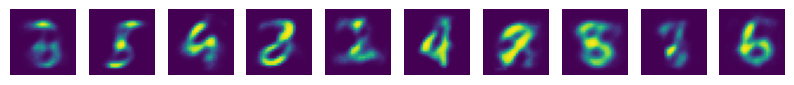

In [14]:
"""
   Plotting
"""
generated_samples = generate_samples(vae, num_samples=10)
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_samples[i].squeeze(), cmap='viridis')
    plt.axis('off')
plt.show()